In [1]:
import torch
import numpy as np
import torchvision
import crypten
import sklearn
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
import crypten.mpc as mpc
import crypten.communicator as comm

/future/u/alexder/anaconda3/envs/cs356v2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
crypten.init()

ALICE = 0
BOB = 1

In [3]:
!ls

all_data.pth			      mnist_train_playground.ipynb
all_targets.pth			      mnist_train_poisoned_playground.ipynb
all_val_data.pth		      one_hot_target
all_val_targets.pth		      poisoned_data_samples
cifar10_raw_pytorch.ipynb	      scalar_target
mnist_data_playground.ipynb	      tutorials
mnist_data_poisoned_playground.ipynb


In [4]:
def train(model, all_data, all_targets, all_val_data, all_val_targets):
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    lr = 0.01
    batch_size = 16
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

    # Define training parameters
    num_epochs = 2
    val_every_n = 10
    num_batches = all_data.size(0) // batch_size
    
    batch_loss = []
    batch_acc = []
    
    for i in range(num_epochs): 
        
        for batch in range(num_batches):
            model.train()
            # define the start and end of the training mini-batch
            start, end = batch * batch_size, (batch + 1) * batch_size
                                    
            # construct CrypTensors out of training examples / labels
            x_train = all_data[start:end]
            y_train = torch.Tensor(all_targets[start:end]).long()
            optimizer.zero_grad()

            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_loss.append(loss)
            optimizer.step()
            
            if (batch % val_every_n == 0):
                print("Validating")
                acc = val(model, all_val_data, all_val_targets)
                batch_acc.append(acc)
                
    return batch_loss, batch_acc

In [5]:
def val(model, all_data, all_targets):
    
    model.eval()
    
    # Define training parameters
    batch_size = 8
    num_batches = all_data.size(0) // batch_size
    
    total_acc = 0
    for batch in range(num_batches):
        start, end = batch * batch_size, (batch + 1) * batch_size

        # construct CrypTensors out of training examples / labels
        x_val = all_data[start:end]
        y_val = torch.Tensor(all_targets[start:end]).long()

        outputs = model(x_val)
        acc = torch.sum(torch.argmax(outputs, dim = 1) == y_val)/ x_val.shape[0]
        total_acc += acc
        
    return total_acc / (num_batches)

In [6]:
!ls poisoned_data_samples

scalar_target


In [7]:
subsample = 0.02
            
@mpc.run_multiprocess(world_size=2)
def data_labeling_example():
    """Apply data labeling access control model"""
    # Alice loads features, Bob loads labels
    data_alice_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/data_0.pth', src=ALICE)
    targets_alice_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/targets_0.pth', src=ALICE)
    
    data_bob_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/data_1.pth', src=BOB)
    targets_bob_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/targets_1.pth', src=BOB)
    
    val_data_alice_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/data_0.pth', src=ALICE)
    val_targets_alice_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/targets_0.pth', src=ALICE)
    
    val_data_bob_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/data_1.pth', src=BOB)
    val_targets_bob_enc = crypten.load_from_party('./poisoned_data_samples/scalar_target/data_samples_sub50x/2/train/targets_1.pth', src=BOB)
    
    model = torchvision.models.resnet50(num_classes = 10)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    all_data = crypten.cat([data_alice_enc, data_bob_enc], dim=0)
    all_targets = crypten.cat([targets_alice_enc, targets_bob_enc], dim=0)
    
    all_val_data = crypten.cat([val_data_alice_enc, val_data_bob_enc], dim=0)
    all_val_targets = crypten.cat([val_targets_alice_enc, val_targets_bob_enc], dim=0)
    
    #train(model, all_data, all_targets)
    all_data_decrypt = all_data.get_plain_text()
    all_targets_decrypt = all_targets.get_plain_text()
    
    all_val_data_decrypt = all_val_data.get_plain_text()
    all_val_targets_decrypt = all_val_targets.get_plain_text()
    
    torch.save(all_data_decrypt, 'all_data.pth')
    torch.save(all_targets_decrypt, 'all_targets.pth')
    
    torch.save(all_val_data_decrypt, 'all_val_data.pth')
    torch.save(all_val_targets_decrypt, 'all_val_targets.pth')
    #return all_data_decrypt, all_targets_decrypt

In [8]:
data_labeling_example()

/future/u/alexder/anaconda3/envs/cs356v2/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/future/u/alexder/anaconda3/envs/cs356v2/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or

[None, None]

In [9]:
all_data = torch.load('all_data.pth')
all_targets = torch.load('all_targets.pth')

all_val_data = torch.load('all_val_data.pth')
all_val_targets = torch.load('all_val_targets.pth')

Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating
Validating


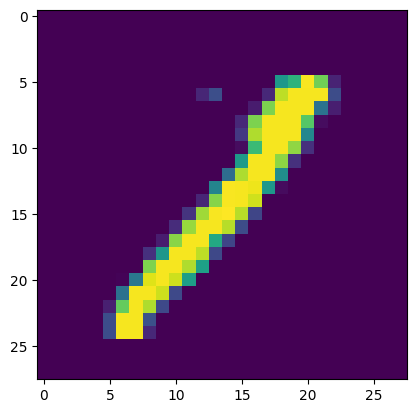

In [15]:
model = torchvision.models.resnet18(num_classes = 10, pretrained = False)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

plt.imshow(all_data[19][0]), all_targets[19]
batch_losses, batch_accs = train(model, all_data, all_targets, all_val_data, all_val_targets)

In [16]:
len(all_data)/8

150.0

Text(0.5, 1.0, 'Batch vs. Loss')

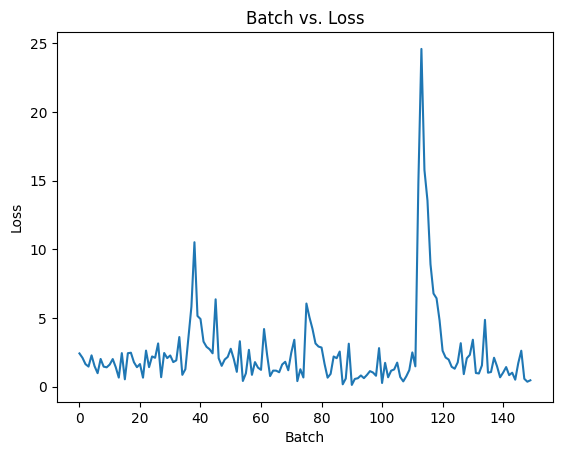

In [17]:
batch_losses = [loss.detach().numpy() for loss in batch_losses]
plt.plot(batch_losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Batch vs. Loss")

Text(0.5, 1.0, 'Batch vs. Val Accuracy (with Poisoned Data)')

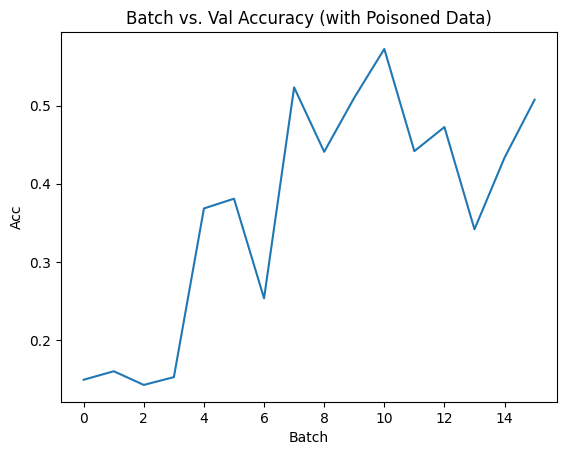

In [18]:
batch_accs = [acc.detach().numpy() for acc in batch_accs]
plt.plot(batch_accs)
plt.xlabel("Batch")
plt.ylabel("Acc")
plt.title("Batch vs. Val Accuracy (with Poisoned Data)")

In [15]:
acc = val(model, all_val_data, all_val_targets)

In [16]:
batch_accs

[array(0.09833334, dtype=float32),
 array(0.15833333, dtype=float32),
 array(0.19083333, dtype=float32),
 array(0.34583333, dtype=float32),
 array(0.47, dtype=float32),
 array(0.29416665, dtype=float32),
 array(0.7775, dtype=float32),
 array(0.6, dtype=float32),
 array(0.85833335, dtype=float32),
 array(0.6, dtype=float32),
 array(0.6408333, dtype=float32),
 array(0.745, dtype=float32),
 array(0.3425, dtype=float32),
 array(0.5825, dtype=float32),
 array(0.62666667, dtype=float32),
 array(0.85083336, dtype=float32)]